In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import ternary # ternary plot has a bug
import plotly.express as px
import h5py
import matplotlib as mpl

import os
import matplotlib.patheffects as path_effects


from netCDF4 import Dataset as NetCDFFile 

# for beachball - there are some error with using obspy
from pyrocko.plot import beachball
from pyrocko import moment_tensor as ptm

import cartopy.crs as ccrs
import cartopy.mpl.geoaxes

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from pathlib import Path
%matplotlib inline

import harmonica as hm


import seaborn as sns
sns.set()
sns.set_style(style='white') 
sns.set_style("ticks", {"xtick.major.size": 0.5, "ytick.major.size": 0.5})

### Upload datasets

#### Earthquakes

In [2]:
data = pd.read_csv('SUeq_data.csv', parse_dates=['DATE'])

# In the above data, we don't have 2005 mega event information
# thus we will use that from another file
df = pd.read_csv('sum_combi_net_10km_step.csv', parse_dates=['DATE'])

#### Topography

In [3]:
nc = NetCDFFile('topo_sumatra.nc')
# print(nc)

In [4]:
print(type(nc)) # print the type of the data 
print(nc.variables.keys()) # print the variables in the data

<class 'netCDF4._netCDF4.Dataset'>
dict_keys(['lon', 'lat', 'z'])


In [5]:
lat = nc.variables['lat'][:]
lon = nc.variables['lon'][:]
z = nc.variables['z'][:]

In [6]:
# creating meshgrid from our list of spatial coordinates
lon, lat = np.meshgrid(lon,lat)

#### Trench

In [7]:
trench_xy = pd.read_csv('SUM_trench.csv', sep=',', header = None)
trench_xy.columns = ['LON', 'LAT'] # column names added
# trench_xy.head()

#### Slab data for the map

In [8]:
slab = NetCDFFile('SUslab_depth.grd')
print(type(slab)) # print the type of the data 
print(slab.variables.keys()) # print the variables in the data

<class 'netCDF4._netCDF4.Dataset'>
dict_keys(['x', 'y', 'z'])


#### Rupture data

In [9]:
sum_rup = pd.read_csv('sum_rupture_length.csv', sep = ',', header = 12)
sum_rup.head()

DATE         TIME      LON     LAT  DEPTH   MW  ALONG  MIN_AL  \
0  2004-12-26  00:58:53.15   95.876   3.299   28.6  9.0   2715    1285   
1  2005-03-28  16:09:43.04   97.459   3.026   25.8  8.6   2845    2785   
2  2007-09-12  11:10:26.21  101.359  -4.458   32.0  8.5   3765    3375   
3  1994-06-02  18:17:38.98  112.950 -10.368   37.4  7.8   5375    5335   
4  2010-10-25  14:42:22.18  100.097  -3.502   22.8  7.8   3575    3465   

   MAX_AL  WIDTH  
0    2735    150  
1    3105    200  
2    3765    170  
3    5445     60  
4    3575     50

In [10]:
lon_slab = slab.variables['x'][:]
lat_slab = slab.variables['y'][:]
depth_slab = slab.variables['z'][:]

# creating meshgrid from our list of spatial coordinates
lon_slab, lat_slab = np.meshgrid(lon_slab, lat_slab)

#### Slab data for depth profile along the trench

In [11]:
# slab
slab_length = pd.read_csv('depth_at_prof_50.csv', sep = ',', header = 'infer')
slab_length=slab_length.append(slab_length, ignore_index=True)
slab_length = slab_length.sort_values(by = 'ALONG',ascending=True)

slab_length = slab_length.sample(frac=0.3, replace=False, random_state=1)

length = np.asarray(slab_length['LENGTH'])

### Seperate data for Upper plate and Downgoing plate and Megathrust

In [12]:
data_100 = data[(data['P(km)'] > 0)] # 100 km towards landwards (130, 180, )
data_UP = data_100.loc[data['CLASS'] == 'UPPER']
# data_UP = data_UP[(data['MW'] >= 6)]

data_slab = data[(data['P(km)'] > 0) & (data['DEPTH'] < 300)] # only in the subducting slab at < 300 km
data_DW = data_slab.loc[data['CLASS'] == 'DGOING']

data_MT = data.loc[data['CLASS'] == 'MTHRUST']

In [13]:
data_UP['P(km)'].min()

4.2140189669999994

In [14]:
data_mega = df.loc[df['CLASS'] == 'MTHRUST']
data_mega = data_mega[data_mega['MW'] >= 7.9]
print(data_mega['MW'])
data_mega.head()

0    9.0
1    8.6
2    8.5
4    7.9
Name: MW, dtype: float64


LON    LAT  DEPTH       DATE         TIME  EVENT_ID DEPFIX DEPQUAL  \
0   95.876  3.299   28.6 2004-12-26  00:58:53.15       732    1.0      L2   
1   97.459  3.026   25.8 2005-03-28  16:09:43.04       733    1.0      L2   
2  101.359 -4.458   32.0 2007-09-12  11:10:26.21       734  False      L1   
4  100.720 -2.671   41.4 2007-09-12  23:49:04.28       735  False      L1   

     EX     MO  ...  P_AZM  N_VAL  N_PL  N_AZM   SLAB_DIP    CLASS  \
0  22.0  3.953  ...  222.0 -0.119   3.0  130.0  14.287827  MTHRUST   
1  22.0  1.050  ...  218.0 -0.002   4.0  125.0  26.674480  MTHRUST   
2  21.0  6.711  ...  216.0 -0.024   3.0  123.0  12.599817  MTHRUST   
4  20.0  8.133  ...  218.0 -0.027   4.0  126.0  22.237041  MTHRUST   

      LON_AVE   LAT_AVE   S_AVE  N_AVE  
0   95.726030  3.171301  2715.0 -125.0  
1   97.298304  2.893791  2845.0 -225.0  
2  101.401758 -4.472555  3765.0 -125.0  
4  100.571766 -2.717707  3545.0 -175.0  

[4 rows x 40 columns]

## Work with the Upper plate

In [15]:
data_T_UP = data_UP.loc[data_UP['TYPE'] == 'THRUST']
data_SS_UP = data_UP.loc[data_UP['TYPE'] == 'SS']
data_N_UP = data_UP.loc[data_UP['TYPE'] == 'NORM']

data_UP_b2004 = data_UP[(data_UP['DATE'] < '2004-12-25')]
data_UP_2yrb2004 = data_UP[(data_UP['DATE'] > '2002-12-25') & (data_UP['DATE'] < '2004-12-25')]
data_UP_a2004 = data_UP[(data_UP['DATE'] > '2004-12-25') & (data_UP['DATE'] < '2005-03-27')]
data_UP_a2005 = data_UP[(data_UP['DATE'] > '2005-03-27') & (data_UP['DATE'] < '2007-09-11')]
data_UP_a2007 = data_UP[(data_UP['DATE'] > '2007-09-11') & (data_UP['DATE'] < '2009-09-11')]

#### Thrust

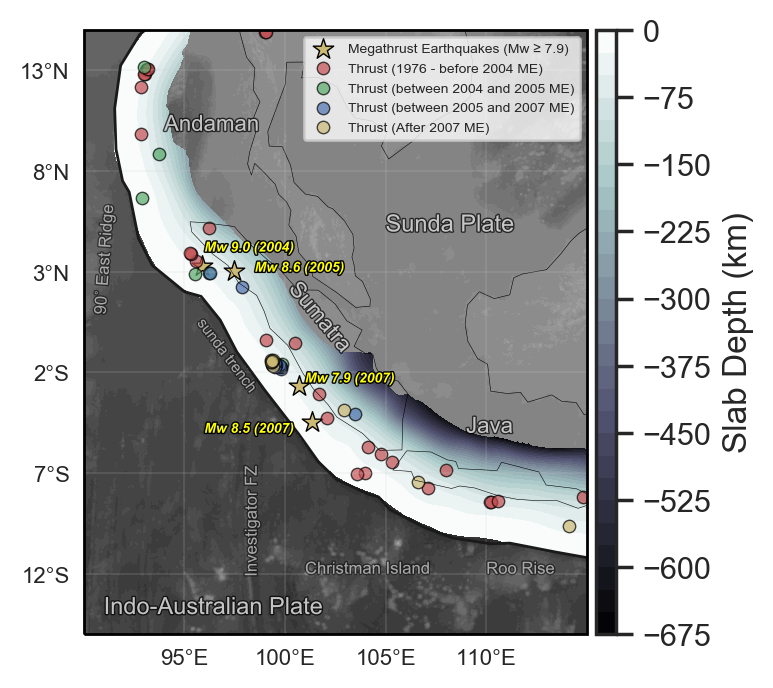

In [16]:
data_T_UP_b2004 = data_T_UP[(data_T_UP['DATE'] < '2004-12-25')]
data_T_UP_a2004 = data_T_UP[(data_T_UP['DATE'] > '2004-12-25') & (data_T_UP['DATE'] < '2005-03-27')]
data_T_UP_a2005 = data_T_UP[(data_T_UP['DATE'] > '2005-03-27') & (data_T_UP['DATE'] < '2007-09-11')]
data_T_UP_a2007 = data_T_UP[(data_T_UP['DATE'] > '2007-09-11') & (data_T_UP['DATE'] < '2015-09-11')]


fig, ax = plt.subplots(dpi = 200)
m = plt.axes(projection = cartopy.crs.PlateCarree())

topo = m.contourf(lon, lat, z, 30,
    transform=ccrs.PlateCarree(), cmap='gray')

slab = m.contourf(lon_slab, lat_slab, depth_slab, 30,
    transform=ccrs.PlateCarree(), cmap='bone')

plt.colorbar(slab, label="Slab Depth (km)", orientation="vertical", aspect=30, pad=0.01, shrink=1)

plt.text(94, 10, 'Andaman', transform=ccrs.PlateCarree(), color='white', fontsize=8, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(100, -1, 'Sumatra', transform=ccrs.PlateCarree(), color='white', fontsize=8, rotation=-50, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(109, -5, 'Java', transform=ccrs.PlateCarree(), color='white', fontsize=8, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

plt.text(95.5, -3, 'sunda trench', transform=ccrs.PlateCarree(), color='white', fontsize=5.5, rotation=-53, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

plt.text(98, -12, 'Investigator FZ', transform=ccrs.PlateCarree(), color='white', fontsize=6, rotation=90, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(101, -12, 'Christman Island', transform=ccrs.PlateCarree(), color='white', fontsize=6, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(110, -12, 'Roo Rise', transform=ccrs.PlateCarree(), color='white', fontsize=6, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(90.5, 1, '90˚ East Ridge', transform=ccrs.PlateCarree(), color='white', fontsize=6, rotation=86, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])


plt.text(91, -14, 'Indo-Australian Plate', transform=ccrs.PlateCarree(), color='white', fontsize=8.5, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(105, 5, 'Sunda Plate', transform=ccrs.PlateCarree(), color='white', fontsize=8.5, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])


m.set_extent([90, 115, -15, 15])

m.add_feature(cartopy.feature.COASTLINE, linewidth = 0.2)
# m.add_feature(cartopy.feature.LAND, linewidth = 0.5, color='grey')
# m.add_feature(cartopy.feature.OCEAN, linewidth = 0.5, color='grey', alpha=0.5)
gl = m.gridlines(linewidth = 0.1, draw_labels = True)
gl.xlocator = mticker.FixedLocator(np.arange(85-10, 125+20, 5))
gl.ylocator = mticker.FixedLocator(np.arange(-17-10, 30+20, 5))
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 8}
gl.xlabel_style = {'size': 8}

# plot the trench
m.plot(trench_xy['LON'], trench_xy['LAT'], '-', c = 'k', linewidth = 1)

#plot mega events as stars
m.scatter(data_mega['LON'], data_mega['LAT'], marker = '*', s = 60, c = 'y', alpha = 1, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Megathrust Earthquakes (Mw ≥ 7.9)')
# add info of mega events
plt.text(96, 4, 'Mw 9.0 (2004)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(98.5, 3, 'Mw 8.6 (2005)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(96, -5, 'Mw 8.5 (2007)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(101, -2.5, 'Mw 7.9 (2007)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

# plot all events
m.scatter(data_T_UP_b2004['LON'], data_T_UP_b2004['LAT'], s = 20, c = 'r', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Thrust (1976 - before 2004 ME)')
m.scatter(data_T_UP_a2004['LON'], data_T_UP_a2004['LAT'], s = 20, c = 'g', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Thrust (between 2004 and 2005 ME)')
m.scatter(data_T_UP_a2005['LON'], data_T_UP_a2005['LAT'], s = 20, c = 'b', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Thrust (between 2005 and 2007 ME)')
m.scatter(data_T_UP_a2007['LON'], data_T_UP_a2007['LAT'], s = 20, c = 'y', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Thrust (After 2007 ME)')

m.legend(loc = 'upper right', fontsize = 5)
# plt.title('Seismicity in the Sunda upper plate', fontsize=9)
plt.savefig('up_t_seis.jpg', dpi = 300, transparent= True, bbox_inches='tight')


# 1, 2, 3 - r, theta, phi 
# M11, M22, M33, M12, M13, M23 - Mrr, Mtt, Mpp, Mrt, Mpr, Mtp



#### Normal

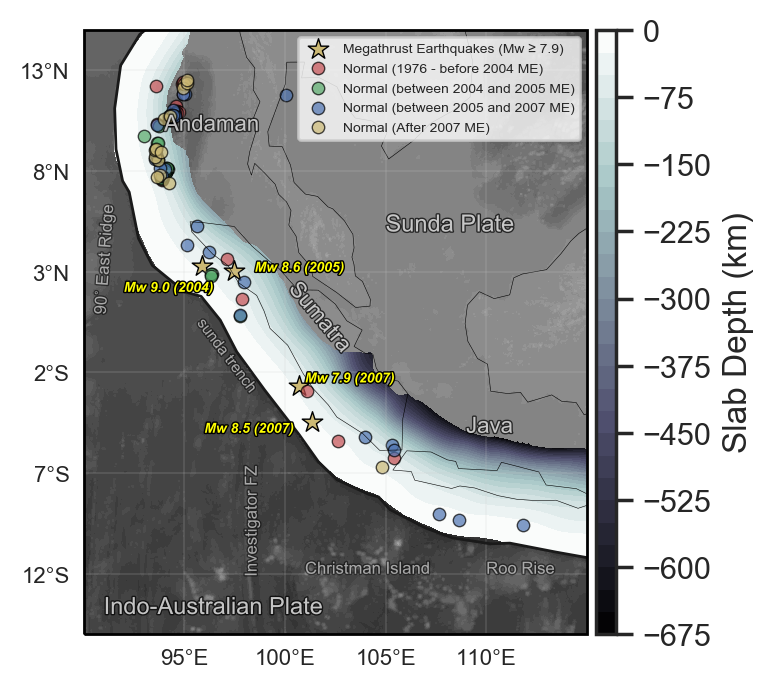

In [17]:
data_N_UP_b2004 = data_N_UP[(data_N_UP['DATE'] < '2004-12-25')]
data_N_UP_a2004 = data_N_UP[(data_N_UP['DATE'] > '2004-12-25') & (data_N_UP['DATE'] < '2005-03-27')]
data_N_UP_a2005 = data_N_UP[(data_N_UP['DATE'] > '2005-03-27') & (data_N_UP['DATE'] < '2007-09-11')]
data_N_UP_a2007 = data_N_UP[(data_N_UP['DATE'] > '2007-09-11') & (data_N_UP['DATE'] < '2015-09-11')]


fig, ax = plt.subplots(dpi = 200)
m = plt.axes(projection = cartopy.crs.PlateCarree())

topo = m.contourf(lon, lat, z, 30,
    transform=ccrs.PlateCarree(), cmap='gray')

slab = m.contourf(lon_slab, lat_slab, depth_slab, 30,
    transform=ccrs.PlateCarree(), cmap='bone')

plt.colorbar(slab, label="Slab Depth (km)", orientation="vertical", aspect=30, pad=0.01, shrink=1)

plt.text(94, 10, 'Andaman', transform=ccrs.PlateCarree(), color='white', fontsize=8, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(100, -1, 'Sumatra', transform=ccrs.PlateCarree(), color='white', fontsize=8, rotation=-50, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(109, -5, 'Java', transform=ccrs.PlateCarree(), color='white', fontsize=8, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

plt.text(95.5, -3, 'sunda trench', transform=ccrs.PlateCarree(), color='white', fontsize=5.5, rotation=-53, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

plt.text(98, -12, 'Investigator FZ', transform=ccrs.PlateCarree(), color='white', fontsize=6, rotation=90, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(101, -12, 'Christman Island', transform=ccrs.PlateCarree(), color='white', fontsize=6, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(110, -12, 'Roo Rise', transform=ccrs.PlateCarree(), color='white', fontsize=6, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(90.5, 1, '90˚ East Ridge', transform=ccrs.PlateCarree(), color='white', fontsize=6, rotation=86, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])


plt.text(91, -14, 'Indo-Australian Plate', transform=ccrs.PlateCarree(), color='white', fontsize=8.5, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(105, 5, 'Sunda Plate', transform=ccrs.PlateCarree(), color='white', fontsize=8.5, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])


m.set_extent([90, 115, -15, 15])

m.add_feature(cartopy.feature.COASTLINE, linewidth = 0.2)
# m.add_feature(cartopy.feature.LAND, linewidth = 0.5, color='grey')
# m.add_feature(cartopy.feature.OCEAN, linewidth = 0.5, color='grey', alpha=0.5)
gl = m.gridlines(linewidth = 0.1, draw_labels = True)
gl.xlocator = mticker.FixedLocator(np.arange(85-10, 125+20, 5))
gl.ylocator = mticker.FixedLocator(np.arange(-17-10, 30+20, 5))
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 8}
gl.xlabel_style = {'size': 8}

# plot the trench
m.plot(trench_xy['LON'], trench_xy['LAT'], '-', c = 'k', linewidth = 1)

#plot mega events as stars
m.scatter(data_mega['LON'], data_mega['LAT'], marker = '*', s = 60, c = 'y', alpha = 1, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Megathrust Earthquakes (Mw ≥ 7.9)')
# add info of mega events
plt.text(92, 2, 'Mw 9.0 (2004)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(98.5, 3, 'Mw 8.6 (2005)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(96, -5, 'Mw 8.5 (2007)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(101, -2.5, 'Mw 7.9 (2007)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

# plot all events
m.scatter(data_N_UP_b2004['LON'], data_N_UP_b2004['LAT'], s = 20, c = 'r', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Normal (1976 - before 2004 ME)')
m.scatter(data_N_UP_a2004['LON'], data_N_UP_a2004['LAT'], s = 20, c = 'g', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Normal (between 2004 and 2005 ME)')
m.scatter(data_N_UP_a2005['LON'], data_N_UP_a2005['LAT'], s = 20, c = 'b', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Normal (between 2005 and 2007 ME)')
m.scatter(data_N_UP_a2007['LON'], data_N_UP_a2007['LAT'], s = 20, c = 'y', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Normal (After 2007 ME)')

m.legend(loc = 'upper right', fontsize = 5)
# plt.title('Seismicity in the Sunda upper plate', fontsize=9)
plt.savefig('up_n_seis.jpg', dpi = 300, transparent= True, bbox_inches='tight')

#### Strike Slip

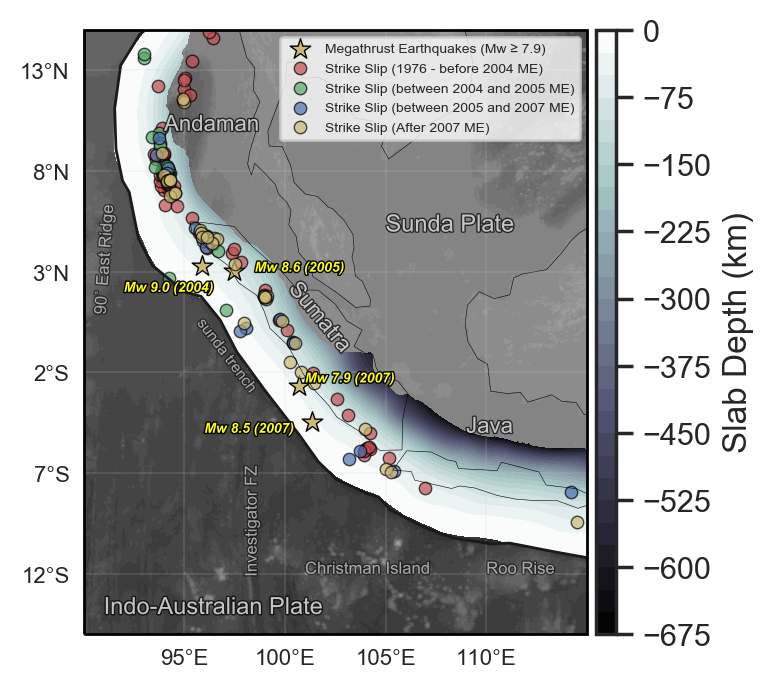

In [18]:
data_SS_UP_b2004 = data_SS_UP[(data_SS_UP['DATE'] < '2004-12-25')]
data_SS_UP_a2004 = data_SS_UP[(data_SS_UP['DATE'] > '2004-12-25') & (data_SS_UP['DATE'] < '2005-03-27')]
data_SS_UP_a2005 = data_SS_UP[(data_SS_UP['DATE'] > '2005-03-27') & (data_SS_UP['DATE'] < '2007-09-11')]
data_SS_UP_a2007 = data_SS_UP[(data_SS_UP['DATE'] > '2007-09-11') & (data_SS_UP['DATE'] < '2015-09-11')]


fig, ax = plt.subplots(dpi = 200)
m = plt.axes(projection = cartopy.crs.PlateCarree())

topo = m.contourf(lon, lat, z, 30,
    transform=ccrs.PlateCarree(), cmap='gray')

slab = m.contourf(lon_slab, lat_slab, depth_slab, 30,
    transform=ccrs.PlateCarree(), cmap='bone')

plt.colorbar(slab, label="Slab Depth (km)", orientation="vertical", aspect=30, pad=0.01, shrink=1)

plt.text(94, 10, 'Andaman', transform=ccrs.PlateCarree(), color='white', fontsize=8, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(100, -1, 'Sumatra', transform=ccrs.PlateCarree(), color='white', fontsize=8, rotation=-50, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(109, -5, 'Java', transform=ccrs.PlateCarree(), color='white', fontsize=8, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

plt.text(95.5, -3, 'sunda trench', transform=ccrs.PlateCarree(), color='white', fontsize=5.5, rotation=-53, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

plt.text(98, -12, 'Investigator FZ', transform=ccrs.PlateCarree(), color='white', fontsize=6, rotation=90, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(101, -12, 'Christman Island', transform=ccrs.PlateCarree(), color='white', fontsize=6, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(110, -12, 'Roo Rise', transform=ccrs.PlateCarree(), color='white', fontsize=6, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(90.5, 1, '90˚ East Ridge', transform=ccrs.PlateCarree(), color='white', fontsize=6, rotation=86, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

plt.text(91, -14, 'Indo-Australian Plate', transform=ccrs.PlateCarree(), color='white', fontsize=8.5, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(105, 5, 'Sunda Plate', transform=ccrs.PlateCarree(), color='white', fontsize=8.5, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])


m.set_extent([90, 115, -15, 15])

m.add_feature(cartopy.feature.COASTLINE, linewidth = 0.2)
# m.add_feature(cartopy.feature.LAND, linewidth = 0.5, color='grey')
# m.add_feature(cartopy.feature.OCEAN, linewidth = 0.5, color='grey', alpha=0.5)
gl = m.gridlines(linewidth = 0.1, draw_labels = True)
gl.xlocator = mticker.FixedLocator(np.arange(85-10, 125+20, 5))
gl.ylocator = mticker.FixedLocator(np.arange(-17-10, 30+20, 5))
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 8}
gl.xlabel_style = {'size': 8}

# plot the trench
m.plot(trench_xy['LON'], trench_xy['LAT'], '-', c = 'k', linewidth = 1)

#plot mega events as stars
m.scatter(data_mega['LON'], data_mega['LAT'], marker = '*', s = 60, c = 'y', alpha = 1, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Megathrust Earthquakes (Mw ≥ 7.9)')
# add info of mega events
plt.text(92, 2, 'Mw 9.0 (2004)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(98.5, 3, 'Mw 8.6 (2005)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(96, -5, 'Mw 8.5 (2007)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(101, -2.5, 'Mw 7.9 (2007)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

# plot all events
m.scatter(data_SS_UP_b2004['LON'], data_SS_UP_b2004['LAT'], s = 20, c = 'r', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Strike Slip (1976 - before 2004 ME)')
m.scatter(data_SS_UP_a2004['LON'], data_SS_UP_a2004['LAT'], s = 20, c = 'g', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Strike Slip (between 2004 and 2005 ME)')
m.scatter(data_SS_UP_a2005['LON'], data_SS_UP_a2005['LAT'], s = 20, c = 'b', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Strike Slip (between 2005 and 2007 ME)')
m.scatter(data_SS_UP_a2007['LON'], data_SS_UP_a2007['LAT'], s = 20, c = 'y', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Strike Slip (After 2007 ME)')

m.legend(loc = 'upper right', fontsize = 5)
# plt.title('Seismicity in the Sunda upper plate', fontsize=9)
plt.savefig('up_ss_seis.jpg', dpi = 300, transparent= True, bbox_inches='tight')

### Upper plate P-axis, T-axis and N-axis

#### 2 yrs before 2004 Mega Event

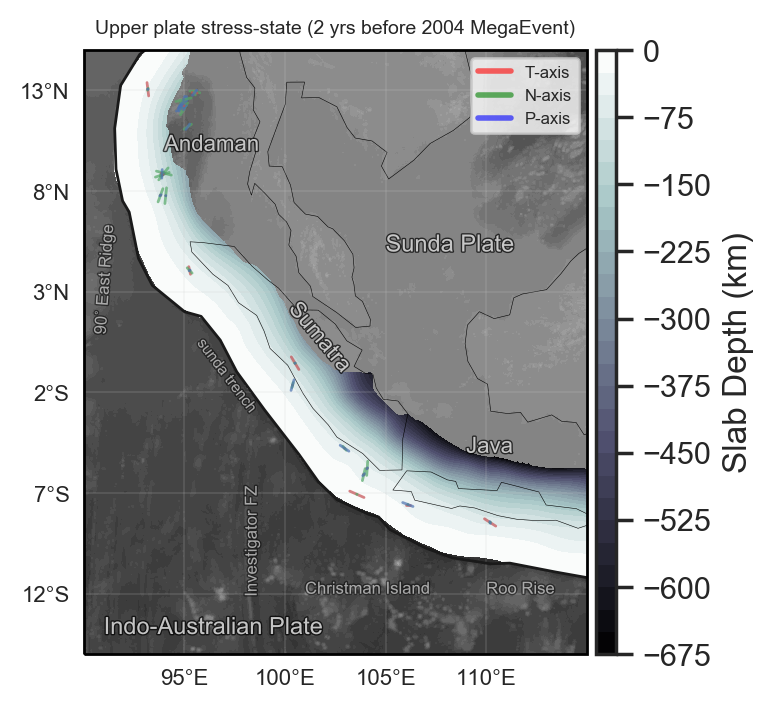

In [19]:
df_to_use = data_UP_2yrb2004.reset_index() # very important to reset

fig, ax = plt.subplots(dpi = 200)
m = plt.axes(projection = cartopy.crs.PlateCarree())

topo = m.contourf(lon, lat, z, 30,
    transform=ccrs.PlateCarree(), cmap='gray')

slab = m.contourf(lon_slab, lat_slab, depth_slab, 30,
    transform=ccrs.PlateCarree(), cmap='bone')

plt.colorbar(slab, label="Slab Depth (km)", orientation="vertical", aspect=30, pad=0.01, shrink=1)

plt.text(94, 10, 'Andaman', transform=ccrs.PlateCarree(), color='white', fontsize=8, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(100, -1, 'Sumatra', transform=ccrs.PlateCarree(), color='white', fontsize=8, rotation=-50, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(109, -5, 'Java', transform=ccrs.PlateCarree(), color='white', fontsize=8, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

plt.text(95.5, -3, 'sunda trench', transform=ccrs.PlateCarree(), color='white', fontsize=5.5, rotation=-53, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

plt.text(98, -12, 'Investigator FZ', transform=ccrs.PlateCarree(), color='white', fontsize=6, rotation=90, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(101, -12, 'Christman Island', transform=ccrs.PlateCarree(), color='white', fontsize=6, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(110, -12, 'Roo Rise', transform=ccrs.PlateCarree(), color='white', fontsize=6, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(90.5, 1, '90˚ East Ridge', transform=ccrs.PlateCarree(), color='white', fontsize=6, rotation=86, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

plt.text(91, -14, 'Indo-Australian Plate', transform=ccrs.PlateCarree(), color='white', fontsize=8.5, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(105, 5, 'Sunda Plate', transform=ccrs.PlateCarree(), color='white', fontsize=8.5, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

m.set_extent([90, 115, -15, 15])

m.add_feature(cartopy.feature.COASTLINE, linewidth = 0.2)
# m.add_feature(cartopy.feature.LAND, linewidth = 0.5, color='grey')
# m.add_feature(cartopy.feature.OCEAN, linewidth = 0.5, color='grey', alpha=0.5)
gl = m.gridlines(linewidth = 0.1, draw_labels = True)
gl.xlocator = mticker.FixedLocator(np.arange(85-10, 125+20, 5))
gl.ylocator = mticker.FixedLocator(np.arange(-17-10, 30+20, 5))
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 8}
gl.xlabel_style = {'size': 8}

# plot the trench
m.plot(trench_xy['LON'], trench_xy['LAT'], '-', c = 'k', linewidth = 1)

# add the T, N, P visualizations
# sine ang dx
t_dx = 0.4*(np.sin(df_to_use['T_PL']*np.pi/180)**2)*np.sin(df_to_use['T_AZM']*np.pi/180)
t_dy = 0.4*(np.sin(df_to_use['T_PL']*np.pi/180)**2)*np.cos(df_to_use['T_AZM']*np.pi/180)

n_dx = 0.4*(np.sin(df_to_use['N_PL']*np.pi/180)**2)*np.sin(df_to_use['N_AZM']*np.pi/180)
n_dy = 0.4*(np.sin(df_to_use['N_PL']*np.pi/180)**2)*np.cos(df_to_use['N_AZM']*np.pi/180)

p_dx = 0.4*(np.sin(df_to_use['P_PL']*np.pi/180)**2)*np.sin(df_to_use['P_AZM']*np.pi/180)
p_dy = 0.4*(np.sin(df_to_use['P_PL']*np.pi/180)**2)*np.cos(df_to_use['P_AZM']*np.pi/180)

#plot mega events as stars
# m.scatter(data_mega['LON'][2], data_mega['LAT'][2], marker = '*', s = 80, c = 'y', alpha = 1, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Megathrust Earthquakes (Mw ≥ 7.9)')
# m.scatter(data_mega['LON'][4], data_mega['LAT'][4], marker = '*', s = 80, c = 'y', alpha = 1, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Megathrust Earthquakes (Mw ≥ 7.9)')


for idx, row in df_to_use.iterrows():
    # plot T
    plt.plot([row['LON'] + t_dx[idx], row['LON'] - t_dx[idx]], [row['LAT'] + t_dy[idx], row['LAT'] - t_dy[idx]], '-', linewidth = 1, c = 'r', transform=cartopy.crs.PlateCarree(), alpha = 0.7)
    plt.plot([row['LON'] + n_dx[idx], row['LON'] - n_dx[idx]], [row['LAT'] + n_dy[idx], row['LAT'] - n_dy[idx]], '-', linewidth = 1, c = 'g', transform=cartopy.crs.PlateCarree(), alpha = 0.7)
    plt.plot([row['LON'] + p_dx[idx], row['LON'] - p_dx[idx]], [row['LAT'] + p_dy[idx], row['LAT'] - p_dy[idx]], '-', linewidth = 1, c = 'b', transform=cartopy.crs.PlateCarree(), alpha = 0.7)

    # plot N
    # plot P

 # manual legend
colors = ['red', 'green', 'blue']
lines = [Line2D([0], [0], color=c, linewidth=2, linestyle='-', alpha = 0.6) for c in colors]
labels = ['T-axis', 'N-axis', 'P-axis']

m.legend(lines, labels, loc = 'upper right', fontsize = 6)
# plt.text(97.6, 13.7, 'Upper plate stress-state (2 yrs after 2007 ME)', transform=ccrs.PlateCarree(), color='black', fontsize=6, 
#          backgroundcolor ='white', alpha=1)

# plt.text(96, 4, 'Mw 9.0 (2004)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
# plt.text(98.5, 3, 'Mw 8.6 (2005)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
# plt.text(96, -5, 'Mw 8.5 (2007)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
# plt.text(101, -2.5, 'Mw 7.9 (2007)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])


plt.title('Upper plate stress-state (2 yrs before 2004 MegaEvent)', fontsize=7)
plt.savefig('up_TNP_2002-04.jpg', dpi = 300, transparent= True, bbox_inches='tight')


#m.legend(loc = 'lower left', fontsize = 6)

#### Between 2004 and 2005 MegaEvent

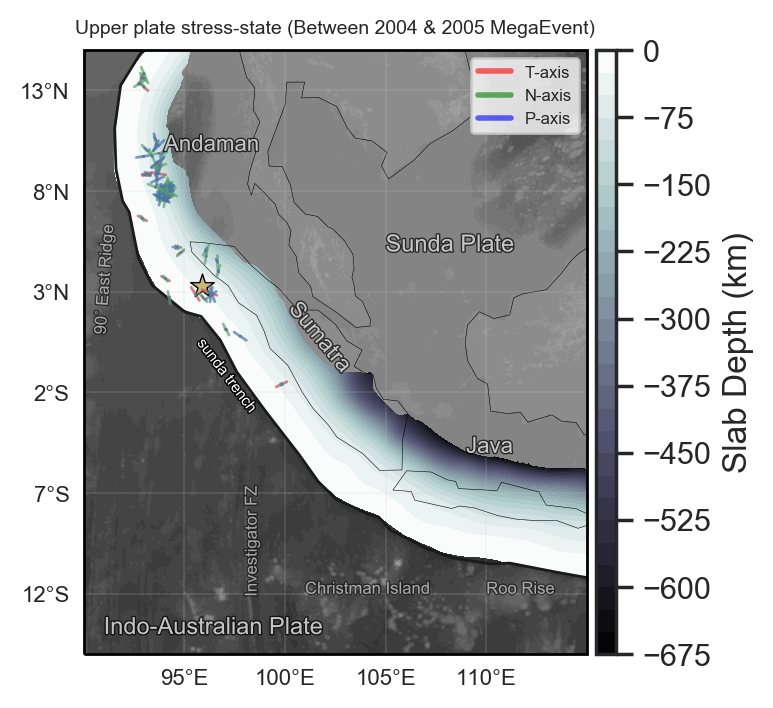

In [20]:
df_to_use = data_UP_a2004.reset_index() # very important to reset

fig, ax = plt.subplots(dpi = 200)
m = plt.axes(projection = cartopy.crs.PlateCarree())

topo = m.contourf(lon, lat, z, 30,
    transform=ccrs.PlateCarree(), cmap='gray')

slab = m.contourf(lon_slab, lat_slab, depth_slab, 30,
    transform=ccrs.PlateCarree(), cmap='bone')

plt.colorbar(slab, label="Slab Depth (km)", orientation="vertical", aspect=30, pad=0.01, shrink=1)

plt.text(94, 10, 'Andaman', transform=ccrs.PlateCarree(), color='white', fontsize=8, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(100, -1, 'Sumatra', transform=ccrs.PlateCarree(), color='white', fontsize=8, rotation=-50, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(109, -5, 'Java', transform=ccrs.PlateCarree(), color='white', fontsize=8, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

plt.text(95.5, -3, 'sunda trench', transform=ccrs.PlateCarree(), color='white', fontsize=5.5, rotation=-53, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

plt.text(98, -12, 'Investigator FZ', transform=ccrs.PlateCarree(), color='white', fontsize=6, rotation=90, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(101, -12, 'Christman Island', transform=ccrs.PlateCarree(), color='white', fontsize=6, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(110, -12, 'Roo Rise', transform=ccrs.PlateCarree(), color='white', fontsize=6, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(90.5, 1, '90˚ East Ridge', transform=ccrs.PlateCarree(), color='white', fontsize=6, rotation=86, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

plt.text(91, -14, 'Indo-Australian Plate', transform=ccrs.PlateCarree(), color='white', fontsize=8.5, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(105, 5, 'Sunda Plate', transform=ccrs.PlateCarree(), color='white', fontsize=8.5, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

plt.text(95.5, -3, 'sunda trench', transform=ccrs.PlateCarree(), color='white', fontsize=5.5, rotation=-53,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
# plt.text(92, -10, 'Indo-Australian Plate', transform=ccrs.PlateCarree(), color='white', fontsize=9,
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
# plt.text(105, 5, 'Sunda Plate', transform=ccrs.PlateCarree(), color='white', fontsize=9,
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

m.set_extent([90, 115, -15, 15])

m.add_feature(cartopy.feature.COASTLINE, linewidth = 0.2)
# m.add_feature(cartopy.feature.LAND, linewidth = 0.5, color='grey')
# m.add_feature(cartopy.feature.OCEAN, linewidth = 0.5, color='grey', alpha=0.5)
gl = m.gridlines(linewidth = 0.1, draw_labels = True)
gl.xlocator = mticker.FixedLocator(np.arange(85-10, 125+20, 5))
gl.ylocator = mticker.FixedLocator(np.arange(-17-10, 30+20, 5))
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 8}
gl.xlabel_style = {'size': 8}

# plot the trench
m.plot(trench_xy['LON'], trench_xy['LAT'], '-', c = 'k', linewidth = 1)

# add the T, N, P visualizations
# sine ang dx
t_dx = 0.4*(np.sin(df_to_use['T_PL']*np.pi/180)**2)*np.sin(df_to_use['T_AZM']*np.pi/180)
t_dy = 0.4*(np.sin(df_to_use['T_PL']*np.pi/180)**2)*np.cos(df_to_use['T_AZM']*np.pi/180)

n_dx = 0.4*(np.sin(df_to_use['N_PL']*np.pi/180)**2)*np.sin(df_to_use['N_AZM']*np.pi/180)
n_dy = 0.4*(np.sin(df_to_use['N_PL']*np.pi/180)**2)*np.cos(df_to_use['N_AZM']*np.pi/180)

p_dx = 0.4*(np.sin(df_to_use['P_PL']*np.pi/180)**2)*np.sin(df_to_use['P_AZM']*np.pi/180)
p_dy = 0.4*(np.sin(df_to_use['P_PL']*np.pi/180)**2)*np.cos(df_to_use['P_AZM']*np.pi/180)

#plot mega events as stars
m.scatter(data_mega['LON'][0], data_mega['LAT'][0], marker = '*', s = 80, c = 'y', alpha = 1, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Megathrust Earthquakes (Mw ≥ 7.9)')
# m.scatter(data_mega['LON'][4], data_mega['LAT'][4], marker = '*', s = 80, c = 'y', alpha = 1, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Megathrust Earthquakes (Mw ≥ 7.9)')

# plt.text(92, 2, 'Mw 9.0 (2004)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
# plt.text(98.5, 3, 'Mw 8.6 (2005)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
# plt.text(96, -5, 'Mw 8.5 (2007)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
# plt.text(101, -2.5, 'Mw 7.9 (2007)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])



for idx, row in df_to_use.iterrows():
    # plot T
    plt.plot([row['LON'] + t_dx[idx], row['LON'] - t_dx[idx]], [row['LAT'] + t_dy[idx], row['LAT'] - t_dy[idx]], '-', linewidth = 1, c = 'r', transform=cartopy.crs.PlateCarree(), alpha = 0.7)
    plt.plot([row['LON'] + n_dx[idx], row['LON'] - n_dx[idx]], [row['LAT'] + n_dy[idx], row['LAT'] - n_dy[idx]], '-', linewidth = 1, c = 'g', transform=cartopy.crs.PlateCarree(), alpha = 0.7)
    plt.plot([row['LON'] + p_dx[idx], row['LON'] - p_dx[idx]], [row['LAT'] + p_dy[idx], row['LAT'] - p_dy[idx]], '-', linewidth = 1, c = 'b', transform=cartopy.crs.PlateCarree(), alpha = 0.7)

    # plot N
    # plot P

 # manual legend
colors = ['red', 'green', 'blue']
lines = [Line2D([0], [0], color=c, linewidth=2, linestyle='-', alpha = 0.6) for c in colors]
labels = ['T-axis', 'N-axis', 'P-axis']

m.legend(lines, labels, loc = 'upper right', fontsize = 6)
# plt.text(97.6, 13.7, 'Upper plate stress-state (2 yrs after 2007 ME)', transform=ccrs.PlateCarree(), color='black', fontsize=6, 
#          backgroundcolor ='white', alpha=1)


plt.title('Upper plate stress-state (Between 2004 & 2005 MegaEvent)', fontsize=7)
plt.savefig('up_TNP_2004-05.jpg', dpi = 300, transparent= True, bbox_inches='tight')


#m.legend(loc = 'lower left', fontsize = 6)

#### Between 2005 and 2007 MegaEvent

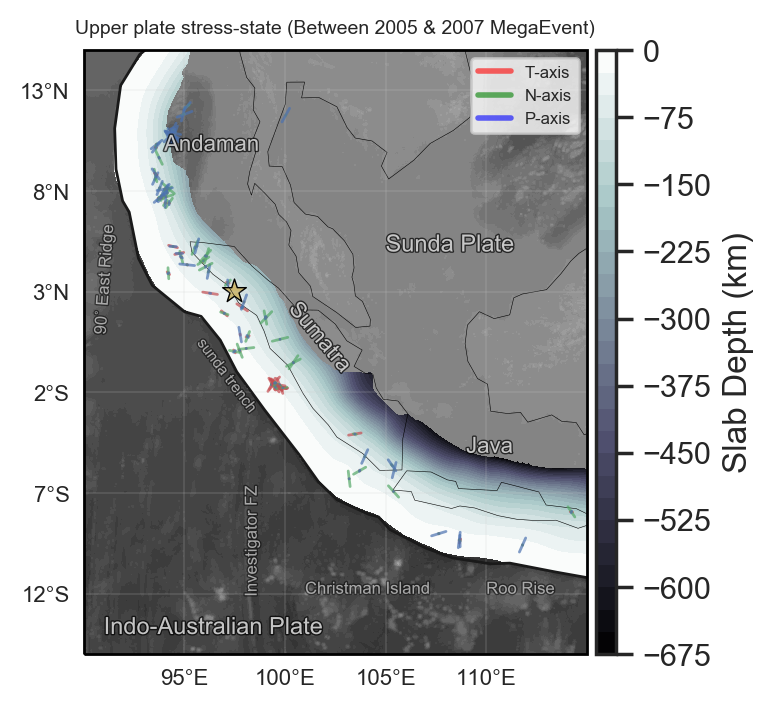

In [21]:
df_to_use = data_UP_a2005.reset_index() # very important to reset

fig, ax = plt.subplots(dpi = 200)
m = plt.axes(projection = cartopy.crs.PlateCarree())

topo = m.contourf(lon, lat, z, 30,
    transform=ccrs.PlateCarree(), cmap='gray')

slab = m.contourf(lon_slab, lat_slab, depth_slab, 30,
    transform=ccrs.PlateCarree(), cmap='bone')

plt.colorbar(slab, label="Slab Depth (km)", orientation="vertical", aspect=30, pad=0.01, shrink=1)

plt.text(94, 10, 'Andaman', transform=ccrs.PlateCarree(), color='white', fontsize=8, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(100, -1, 'Sumatra', transform=ccrs.PlateCarree(), color='white', fontsize=8, rotation=-50, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(109, -5, 'Java', transform=ccrs.PlateCarree(), color='white', fontsize=8, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

plt.text(95.5, -3, 'sunda trench', transform=ccrs.PlateCarree(), color='white', fontsize=5.5, rotation=-53, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

plt.text(98, -12, 'Investigator FZ', transform=ccrs.PlateCarree(), color='white', fontsize=6, rotation=90, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(101, -12, 'Christman Island', transform=ccrs.PlateCarree(), color='white', fontsize=6, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(110, -12, 'Roo Rise', transform=ccrs.PlateCarree(), color='white', fontsize=6, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(90.5, 1, '90˚ East Ridge', transform=ccrs.PlateCarree(), color='white', fontsize=6, rotation=86, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

plt.text(91, -14, 'Indo-Australian Plate', transform=ccrs.PlateCarree(), color='white', fontsize=8.5, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(105, 5, 'Sunda Plate', transform=ccrs.PlateCarree(), color='white', fontsize=8.5, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

m.set_extent([90, 115, -15, 15])

m.add_feature(cartopy.feature.COASTLINE, linewidth = 0.2)
# m.add_feature(cartopy.feature.LAND, linewidth = 0.5, color='grey')
# m.add_feature(cartopy.feature.OCEAN, linewidth = 0.5, color='grey', alpha=0.5)
gl = m.gridlines(linewidth = 0.1, draw_labels = True)
gl.xlocator = mticker.FixedLocator(np.arange(85-10, 125+20, 5))
gl.ylocator = mticker.FixedLocator(np.arange(-17-10, 30+20, 5))
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 8}
gl.xlabel_style = {'size': 8}

# plot the trench
m.plot(trench_xy['LON'], trench_xy['LAT'], '-', c = 'k', linewidth = 1)

# add the T, N, P visualizations
# sine ang dx
t_dx = 0.4*(np.sin(df_to_use['T_PL']*np.pi/180)**2)*np.sin(df_to_use['T_AZM']*np.pi/180)
t_dy = 0.4*(np.sin(df_to_use['T_PL']*np.pi/180)**2)*np.cos(df_to_use['T_AZM']*np.pi/180)

n_dx = 0.4*(np.sin(df_to_use['N_PL']*np.pi/180)**2)*np.sin(df_to_use['N_AZM']*np.pi/180)
n_dy = 0.4*(np.sin(df_to_use['N_PL']*np.pi/180)**2)*np.cos(df_to_use['N_AZM']*np.pi/180)

p_dx = 0.4*(np.sin(df_to_use['P_PL']*np.pi/180)**2)*np.sin(df_to_use['P_AZM']*np.pi/180)
p_dy = 0.4*(np.sin(df_to_use['P_PL']*np.pi/180)**2)*np.cos(df_to_use['P_AZM']*np.pi/180)

#plot mega events as stars
m.scatter(data_mega['LON'][1], data_mega['LAT'][1], marker = '*', s = 80, c = 'y', alpha = 1, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Megathrust Earthquakes (Mw ≥ 7.9)')
# m.scatter(data_mega['LON'][4], data_mega['LAT'][4], marker = '*', s = 80, c = 'y', alpha = 1, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Megathrust Earthquakes (Mw ≥ 7.9)')

# plt.text(92, 2, 'Mw 9.0 (2004)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
# plt.text(98.5, 3, 'Mw 8.6 (2005)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
# plt.text(96, -5, 'Mw 8.5 (2007)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
# plt.text(101, -2.5, 'Mw 7.9 (2007)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])



for idx, row in df_to_use.iterrows():
    # plot T
    plt.plot([row['LON'] + t_dx[idx], row['LON'] - t_dx[idx]], [row['LAT'] + t_dy[idx], row['LAT'] - t_dy[idx]], '-', linewidth = 1, c = 'r', transform=cartopy.crs.PlateCarree(), alpha = 0.7)
    plt.plot([row['LON'] + n_dx[idx], row['LON'] - n_dx[idx]], [row['LAT'] + n_dy[idx], row['LAT'] - n_dy[idx]], '-', linewidth = 1, c = 'g', transform=cartopy.crs.PlateCarree(), alpha = 0.7)
    plt.plot([row['LON'] + p_dx[idx], row['LON'] - p_dx[idx]], [row['LAT'] + p_dy[idx], row['LAT'] - p_dy[idx]], '-', linewidth = 1, c = 'b', transform=cartopy.crs.PlateCarree(), alpha = 0.7)

    # plot N
    # plot P

 # manual legend
colors = ['red', 'green', 'blue']
lines = [Line2D([0], [0], color=c, linewidth=2, linestyle='-', alpha = 0.6) for c in colors]
labels = ['T-axis', 'N-axis', 'P-axis']

m.legend(lines, labels, loc = 'upper right', fontsize = 6)
# plt.text(97.6, 13.7, 'Upper plate stress-state (2 yrs after 2007 ME)', transform=ccrs.PlateCarree(), color='black', fontsize=6, 
#          backgroundcolor ='white', alpha=1)


plt.title('Upper plate stress-state (Between 2005 & 2007 MegaEvent)', fontsize=7)
plt.savefig('up_TNP_2005-07.jpg', dpi = 300, transparent= True, bbox_inches='tight')


#m.legend(loc = 'lower left', fontsize = 6)

#### 2 yrs after 2007 MegaEvent

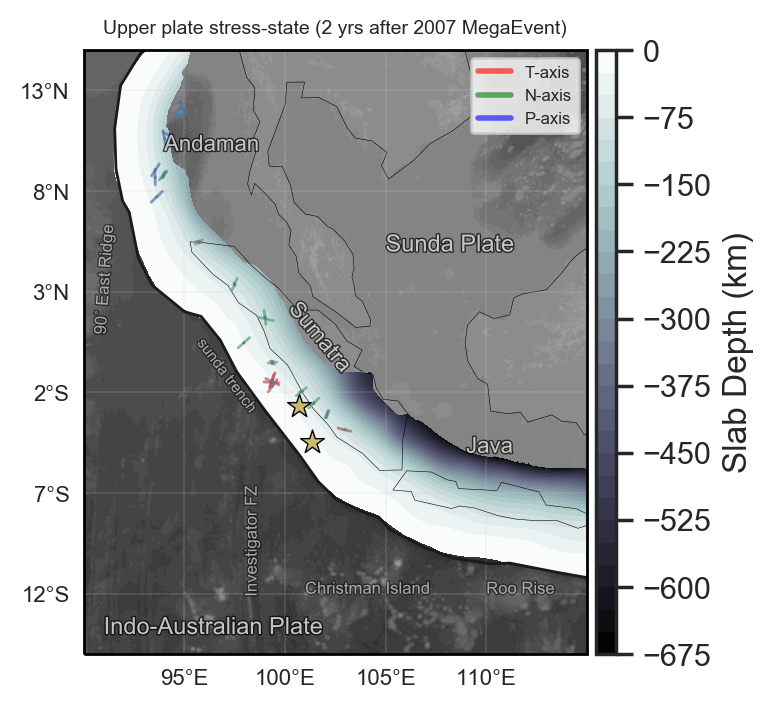

In [22]:
df_to_use = data_UP_a2007.reset_index() # very important to reset

fig, ax = plt.subplots(dpi = 200)
m = plt.axes(projection = cartopy.crs.PlateCarree())

topo = m.contourf(lon, lat, z, 30,
    transform=ccrs.PlateCarree(), cmap='gray')

slab = m.contourf(lon_slab, lat_slab, depth_slab, 30,
    transform=ccrs.PlateCarree(), cmap='bone')

plt.colorbar(slab, label="Slab Depth (km)", orientation="vertical", aspect=30, pad=0.01, shrink=1)

plt.text(94, 10, 'Andaman', transform=ccrs.PlateCarree(), color='white', fontsize=8, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(100, -1, 'Sumatra', transform=ccrs.PlateCarree(), color='white', fontsize=8, rotation=-50, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(109, -5, 'Java', transform=ccrs.PlateCarree(), color='white', fontsize=8, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

plt.text(95.5, -3, 'sunda trench', transform=ccrs.PlateCarree(), color='white', fontsize=5.5, rotation=-53, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

plt.text(98, -12, 'Investigator FZ', transform=ccrs.PlateCarree(), color='white', fontsize=6, rotation=90, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(101, -12, 'Christman Island', transform=ccrs.PlateCarree(), color='white', fontsize=6, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(110, -12, 'Roo Rise', transform=ccrs.PlateCarree(), color='white', fontsize=6, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(90.5, 1, '90˚ East Ridge', transform=ccrs.PlateCarree(), color='white', fontsize=6, rotation=86, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

plt.text(91, -14, 'Indo-Australian Plate', transform=ccrs.PlateCarree(), color='white', fontsize=8.5, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(105, 5, 'Sunda Plate', transform=ccrs.PlateCarree(), color='white', fontsize=8.5, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

m.set_extent([90, 115, -15, 15])

m.add_feature(cartopy.feature.COASTLINE, linewidth = 0.2)
# m.add_feature(cartopy.feature.LAND, linewidth = 0.5, color='grey')
# m.add_feature(cartopy.feature.OCEAN, linewidth = 0.5, color='grey', alpha=0.5)
gl = m.gridlines(linewidth = 0.1, draw_labels = True)
gl.xlocator = mticker.FixedLocator(np.arange(85-10, 125+20, 5))
gl.ylocator = mticker.FixedLocator(np.arange(-17-10, 30+20, 5))
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 8}
gl.xlabel_style = {'size': 8}

# plot the trench
m.plot(trench_xy['LON'], trench_xy['LAT'], '-', c = 'k', linewidth = 1)

# add the T, N, P visualizations
# sine ang dx
t_dx = 0.4*(np.sin(df_to_use['T_PL']*np.pi/180)**2)*np.sin(df_to_use['T_AZM']*np.pi/180)
t_dy = 0.4*(np.sin(df_to_use['T_PL']*np.pi/180)**2)*np.cos(df_to_use['T_AZM']*np.pi/180)

n_dx = 0.4*(np.sin(df_to_use['N_PL']*np.pi/180)**2)*np.sin(df_to_use['N_AZM']*np.pi/180)
n_dy = 0.4*(np.sin(df_to_use['N_PL']*np.pi/180)**2)*np.cos(df_to_use['N_AZM']*np.pi/180)

p_dx = 0.4*(np.sin(df_to_use['P_PL']*np.pi/180)**2)*np.sin(df_to_use['P_AZM']*np.pi/180)
p_dy = 0.4*(np.sin(df_to_use['P_PL']*np.pi/180)**2)*np.cos(df_to_use['P_AZM']*np.pi/180)

#plot mega events as stars
m.scatter(data_mega['LON'][2], data_mega['LAT'][2], marker = '*', s = 80, c = 'y', alpha = 1, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Megathrust Earthquakes (Mw ≥ 7.9)')
m.scatter(data_mega['LON'][4], data_mega['LAT'][4], marker = '*', s = 80, c = 'y', alpha = 1, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Megathrust Earthquakes (Mw ≥ 7.9)')

# plt.text(92, 2, 'Mw 9.0 (2004)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
# plt.text(98.5, 3, 'Mw 8.6 (2005)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
# plt.text(96, -5, 'Mw 8.5 (2007)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
# plt.text(101, -2.5, 'Mw 7.9 (2007)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])



for idx, row in df_to_use.iterrows():
    # plot T
    plt.plot([row['LON'] + t_dx[idx], row['LON'] - t_dx[idx]], [row['LAT'] + t_dy[idx], row['LAT'] - t_dy[idx]], '-', linewidth = 1, c = 'r', transform=cartopy.crs.PlateCarree(), alpha = 0.7)
    plt.plot([row['LON'] + n_dx[idx], row['LON'] - n_dx[idx]], [row['LAT'] + n_dy[idx], row['LAT'] - n_dy[idx]], '-', linewidth = 1, c = 'g', transform=cartopy.crs.PlateCarree(), alpha = 0.7)
    plt.plot([row['LON'] + p_dx[idx], row['LON'] - p_dx[idx]], [row['LAT'] + p_dy[idx], row['LAT'] - p_dy[idx]], '-', linewidth = 1, c = 'b', transform=cartopy.crs.PlateCarree(), alpha = 0.7)

    # plot N
    # plot P

 # manual legend
colors = ['red', 'green', 'blue']
lines = [Line2D([0], [0], color=c, linewidth=2, linestyle='-', alpha = 0.6) for c in colors]
labels = ['T-axis', 'N-axis', 'P-axis']

m.legend(lines, labels, loc = 'upper right', fontsize = 6)
# plt.text(97.6, 13.7, 'Upper plate stress-state (2 yrs after 2007 ME)', transform=ccrs.PlateCarree(), color='black', fontsize=6, 
#          backgroundcolor ='white', alpha=1)


plt.title('Upper plate stress-state (2 yrs after 2007 MegaEvent)', fontsize=7)
plt.savefig('up_TNP_2007-09.jpg', dpi = 300, transparent= True, bbox_inches='tight')


#m.legend(loc = 'lower left', fontsize = 6)

## Downgoing plate

In [23]:
# data_DW = data_DW[(data_DW['DATE'] > '2007-09-11') & (data_DW['DATE'] < '2009-09-11')]

data_T_DW = data_DW.loc[data_DW['TYPE'] == 'THRUST']
data_SS_DW = data_DW.loc[data_DW['TYPE'] == 'SS']
data_N_DW = data_DW.loc[data_DW['TYPE'] == 'NORM']

# data_N_SS_DW = data_DW.loc[(data_DW['TYPE'] == 'NORM') | (data_DW['TYPE'] == 'SS')]
# data_T_UP = data_UP.loc[(data_UP['TYPE'] == 'THRUST') | (data_UP['TYPE'] == 'O_THRUST')]

In [24]:
data_DW_b2004 = data_DW[(data_DW['DATE'] > '2002-12-25') & (data_DW['DATE'] < '2004-12-25')]
data_T_DW_b2004 = data_T_DW[data_T_DW['DATE'] < '2004-12-25']
data_N_DW_b2004 = data_N_DW[data_N_DW['DATE'] < '2004-12-25']
data_SS_DW_b2004 = data_SS_DW[data_SS_DW['DATE'] < '2004-12-25']


data_DW_a2004 = data_DW[(data_DW['DATE'] > '2004-12-25') & (data_DW['DATE'] < '2005-03-27')]
data_T_DW_a2004 = data_T_DW[(data_T_DW['DATE'] > '2004-12-25') & (data_T_DW['DATE'] < '2005-03-27')]
data_N_DW_a2004 = data_N_DW[(data_N_DW['DATE'] > '2004-12-25') & (data_N_DW['DATE'] < '2005-03-27')]
data_SS_DW_a2004 = data_SS_DW[(data_SS_DW['DATE'] > '2004-12-25') & (data_SS_DW['DATE'] < '2005-03-27')]

data_DW_a2005 = data_DW[(data_DW['DATE'] > '2005-03-27') & (data_DW['DATE'] < '2007-09-11')]
data_T_DW_a2005 = data_T_DW[(data_T_DW['DATE'] > '2005-03-27') & (data_T_DW['DATE'] < '2007-09-11')]
data_N_DW_a2005 = data_N_DW[(data_T_DW['DATE'] > '2005-03-27') & (data_N_DW['DATE'] < '2007-09-11')]
data_SS_DW_a2005 = data_SS_DW[(data_SS_DW['DATE'] > '2005-03-27') & (data_SS_DW['DATE'] < '2007-09-11')]


data_DW_a2007 = data_DW[(data_DW['DATE'] > '2007-09-11') & (data_T_DW['DATE'] < '2009-09-11')]
data_T_DW_a2007 = data_T_DW[(data_T_DW['DATE'] > '2007-09-11') & (data_T_DW['DATE'] < '2009-09-11')]
data_N_DW_a2007 = data_N_DW[(data_N_DW['DATE'] > '2007-09-11') & (data_N_DW['DATE'] < '2009-09-11')]
data_SS_DW_a2007 = data_SS_DW[(data_N_DW['DATE'] > '2007-09-11') & (data_SS_DW['DATE'] < '2009-09-11')]

/Users/mohd0001/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/mohd0001/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


### DW seismicity maps

#### 2 yrs before 2004 ME

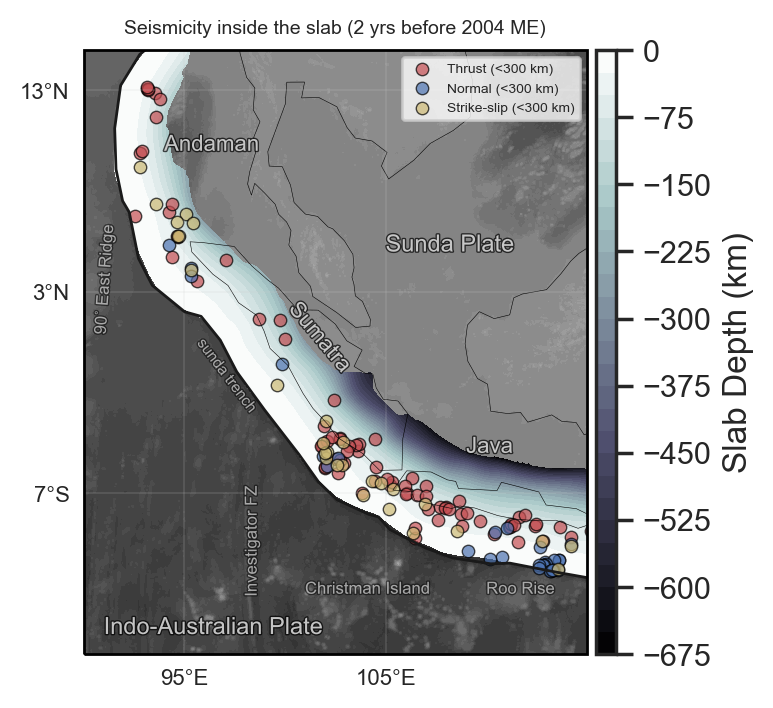

In [25]:
fig, ax = plt.subplots(dpi = 200)
m = plt.axes(projection = cartopy.crs.PlateCarree())

topo = m.contourf(lon, lat, z, 30,
    transform=ccrs.PlateCarree(), cmap='gray')

slab = m.contourf(lon_slab, lat_slab, depth_slab, 30,
    transform=ccrs.PlateCarree(), cmap='bone')

plt.colorbar(slab, label="Slab Depth (km)", orientation="vertical", aspect=30, pad=0.01, shrink=1)

plt.text(94, 10, 'Andaman', transform=ccrs.PlateCarree(), color='white', fontsize=8, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(100, -1, 'Sumatra', transform=ccrs.PlateCarree(), color='white', fontsize=8, rotation=-50, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(109, -5, 'Java', transform=ccrs.PlateCarree(), color='white', fontsize=8, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

plt.text(95.5, -3, 'sunda trench', transform=ccrs.PlateCarree(), color='white', fontsize=5.5, rotation=-53, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

plt.text(98, -12, 'Investigator FZ', transform=ccrs.PlateCarree(), color='white', fontsize=6, rotation=90, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(101, -12, 'Christman Island', transform=ccrs.PlateCarree(), color='white', fontsize=6, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(110, -12, 'Roo Rise', transform=ccrs.PlateCarree(), color='white', fontsize=6, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(90.5, 1, '90˚ East Ridge', transform=ccrs.PlateCarree(), color='white', fontsize=6, rotation=86, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

plt.text(91, -14, 'Indo-Australian Plate', transform=ccrs.PlateCarree(), color='white', fontsize=8.5, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(105, 5, 'Sunda Plate', transform=ccrs.PlateCarree(), color='white', fontsize=8.5, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])


m.set_extent([90, 115, -15, 15])

m.add_feature(cartopy.feature.COASTLINE, linewidth = 0.2)
# m.add_feature(cartopy.feature.LAND, linewidth = 0.5, color='grey')
# m.add_feature(cartopy.feature.OCEAN, linewidth = 0.5, color='grey', alpha=0.5)
gl = m.gridlines(linewidth = 0.1, draw_labels = True)
gl.xlocator = mticker.FixedLocator(np.arange(85-10, 125+20, 10))
gl.ylocator = mticker.FixedLocator(np.arange(-17-10, 30+20, 10))
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 8}
gl.xlabel_style = {'size': 8}

#plot events
# m.scatter(data_mega['LON'][2], data_mega['LAT'][2], marker = '*', s = 60, c = 'y', alpha = 0.9, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Megathrust Earthquake')
# m.scatter(data_mega['LON'][4], data_mega['LAT'][4], marker = '*', s = 60, c = 'y', alpha = 0.9, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree())


m.scatter(data_T_DW_b2004['LON'], data_T_DW_b2004['LAT'], s = 20, c = 'r', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Thrust (<300 km)')
m.scatter(data_N_DW_b2004['LON'], data_N_DW_b2004['LAT'], s = 20, c = 'b', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Normal (<300 km)')
m.scatter(data_SS_DW_b2004['LON'], data_SS_DW_b2004['LAT'], s = 20, c = 'y', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Strike-slip (<300 km)')

# m.scatter(data_T_DW_a2004['LON'], data_T_DW_a2004['LAT'], s = 20, c = 'r', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Thrust (<300 km)')
# m.scatter(data_N_DW_a2004['LON'], data_N_DW_a2004['LAT'], s = 20, c = 'b', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Normal (<300 km)')
# m.scatter(data_SS_DW_a2004['LON'], data_SS_DW_a2004['LAT'], s = 20, c = 'y', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Strike-slip (<300 km)')

# m.scatter(data_T_DW_a2005['LON'], data_T_DW_a2005['LAT'], s = 20, c = 'r', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Thrust (<300 km)')
# m.scatter(data_N_DW_a2005['LON'], data_N_DW_a2005['LAT'], s = 20, c = 'b', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Normal (<300 km)')
# m.scatter(data_SS_DW_a2005['LON'], data_SS_DW_a2005['LAT'], s = 20, c = 'y', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Strike-slip (<300 km)')

# m.scatter(data_T_DW_a2007['LON'], data_T_DW_a2007['LAT'], s = 20, c = 'r', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Thrust (<300 km)')
# m.scatter(data_N_DW_a2007['LON'], data_N_DW_a2007['LAT'], s = 20, c = 'b', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Normal (<300 km)')
# m.scatter(data_SS_DW_a2007['LON'], data_SS_DW_a2007['LAT'], s = 20, c = 'y', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Strike-slip (<300 km)')


# plt.text(96, 4, 'Mw 9.0 (2004)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
# plt.text(98.5, 3, 'Mw 8.6 (2005)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
# plt.text(96, -5, 'Mw 8.5 (2007)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
# plt.text(101, -2.5, 'Mw 7.9 (2007)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])



m.plot(trench_xy['LON'], trench_xy['LAT'], '-', c = 'k', linewidth = 1)
m.legend(loc = 'upper right', fontsize = 5)

plt.title('Seismicity inside the slab (2 yrs before 2004 ME)', fontsize=7)
# plt.title('Seismicity inside the slab (between 2005 & 2007 ME)', fontsize=6)

plt.savefig('dw_2002-04.jpg', dpi = 300, transparent= True, bbox_inches='tight')

# 1, 2, 3 - r, theta, phi 
# M11, M22, M33, M12, M13, M23 - Mrr, Mtt, Mpp, Mrt, Mpr, Mtp


#### Between 2004 & 2005 ME

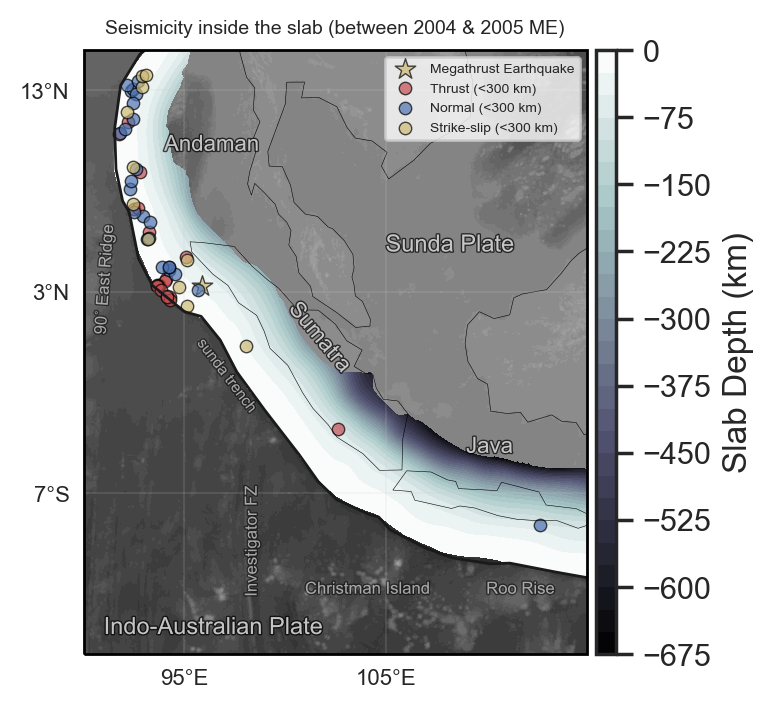

In [26]:
fig, ax = plt.subplots(dpi = 200)
m = plt.axes(projection = cartopy.crs.PlateCarree())

topo = m.contourf(lon, lat, z, 30,
    transform=ccrs.PlateCarree(), cmap='gray')

slab = m.contourf(lon_slab, lat_slab, depth_slab, 30,
    transform=ccrs.PlateCarree(), cmap='bone')

plt.colorbar(slab, label="Slab Depth (km)", orientation="vertical", aspect=30, pad=0.01, shrink=1)

plt.text(94, 10, 'Andaman', transform=ccrs.PlateCarree(), color='white', fontsize=8, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(100, -1, 'Sumatra', transform=ccrs.PlateCarree(), color='white', fontsize=8, rotation=-50, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(109, -5, 'Java', transform=ccrs.PlateCarree(), color='white', fontsize=8, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

plt.text(95.5, -3, 'sunda trench', transform=ccrs.PlateCarree(), color='white', fontsize=5.5, rotation=-53, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

plt.text(98, -12, 'Investigator FZ', transform=ccrs.PlateCarree(), color='white', fontsize=6, rotation=90, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(101, -12, 'Christman Island', transform=ccrs.PlateCarree(), color='white', fontsize=6, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(110, -12, 'Roo Rise', transform=ccrs.PlateCarree(), color='white', fontsize=6, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(90.5, 1, '90˚ East Ridge', transform=ccrs.PlateCarree(), color='white', fontsize=6, rotation=86, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

plt.text(91, -14, 'Indo-Australian Plate', transform=ccrs.PlateCarree(), color='white', fontsize=8.5, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(105, 5, 'Sunda Plate', transform=ccrs.PlateCarree(), color='white', fontsize=8.5, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

m.set_extent([90, 115, -15, 15])

m.add_feature(cartopy.feature.COASTLINE, linewidth = 0.2)
# m.add_feature(cartopy.feature.LAND, linewidth = 0.5, color='grey')
# m.add_feature(cartopy.feature.OCEAN, linewidth = 0.5, color='grey', alpha=0.5)
gl = m.gridlines(linewidth = 0.1, draw_labels = True)
gl.xlocator = mticker.FixedLocator(np.arange(85-10, 125+20, 10))
gl.ylocator = mticker.FixedLocator(np.arange(-17-10, 30+20, 10))
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 8}
gl.xlabel_style = {'size': 8}

#plot events
m.scatter(data_mega['LON'][0], data_mega['LAT'][0], marker = '*', s = 60, c = 'y', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Megathrust Earthquake')
# m.scatter(data_mega['LON'][4], data_mega['LAT'][4], marker = '*', s = 60, c = 'y', alpha = 0.9, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree())


# m.scatter(data_T_DW_b2004['LON'], data_T_DW_b2004['LAT'], s = 20, c = 'r', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Thrust (<300 km)')
# m.scatter(data_N_DW_b2004['LON'], data_N_DW_b2004['LAT'], s = 20, c = 'b', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Normal (<300 km)')
# m.scatter(data_SS_DW_b2004['LON'], data_SS_DW_b2004['LAT'], s = 20, c = 'y', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Strike-slip (<300 km)')

m.scatter(data_T_DW_a2004['LON'], data_T_DW_a2004['LAT'], s = 20, c = 'r', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Thrust (<300 km)')
m.scatter(data_N_DW_a2004['LON'], data_N_DW_a2004['LAT'], s = 20, c = 'b', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Normal (<300 km)')
m.scatter(data_SS_DW_a2004['LON'], data_SS_DW_a2004['LAT'], s = 20, c = 'y', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Strike-slip (<300 km)')

# m.scatter(data_T_DW_a2005['LON'], data_T_DW_a2005['LAT'], s = 20, c = 'r', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Thrust (<300 km)')
# m.scatter(data_N_DW_a2005['LON'], data_N_DW_a2005['LAT'], s = 20, c = 'b', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Normal (<300 km)')
# m.scatter(data_SS_DW_a2005['LON'], data_SS_DW_a2005['LAT'], s = 20, c = 'y', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Strike-slip (<300 km)')

# m.scatter(data_T_DW_a2007['LON'], data_T_DW_a2007['LAT'], s = 20, c = 'r', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Thrust (<300 km)')
# m.scatter(data_N_DW_a2007['LON'], data_N_DW_a2007['LAT'], s = 20, c = 'b', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Normal (<300 km)')
# m.scatter(data_SS_DW_a2007['LON'], data_SS_DW_a2007['LAT'], s = 20, c = 'y', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Strike-slip (<300 km)')


# plt.text(96, 4, 'Mw 9.0 (2004)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
# plt.text(98.5, 3, 'Mw 8.6 (2005)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
# plt.text(96, -5, 'Mw 8.5 (2007)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
# plt.text(101, -2.5, 'Mw 7.9 (2007)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])



m.plot(trench_xy['LON'], trench_xy['LAT'], '-', c = 'k', linewidth = 1)
m.legend(loc = 'upper right', fontsize = 5)

plt.title('Seismicity inside the slab (between 2004 & 2005 ME)', fontsize=7)
# plt.title('Seismicity inside the slab (between 2005 & 2007 ME)', fontsize=6)

plt.savefig('dw_2004-05.jpg', dpi = 300, transparent= True, bbox_inches='tight')

# 1, 2, 3 - r, theta, phi 
# M11, M22, M33, M12, M13, M23 - Mrr, Mtt, Mpp, Mrt, Mpr, Mtp

#### Between 2005 & 2007 ME

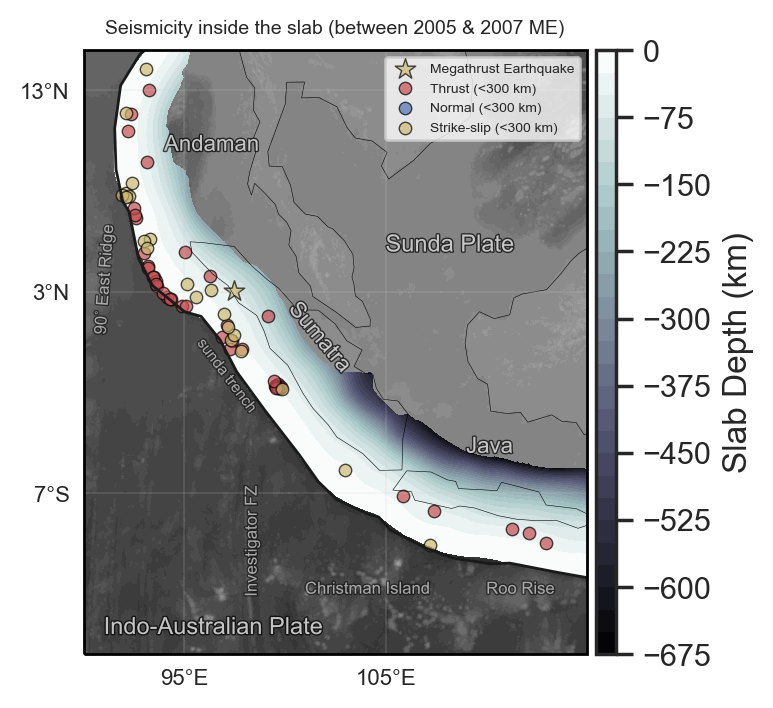

In [27]:
fig, ax = plt.subplots(dpi = 200)
m = plt.axes(projection = cartopy.crs.PlateCarree())

topo = m.contourf(lon, lat, z, 30,
    transform=ccrs.PlateCarree(), cmap='gray')

slab = m.contourf(lon_slab, lat_slab, depth_slab, 30,
    transform=ccrs.PlateCarree(), cmap='bone')

plt.colorbar(slab, label="Slab Depth (km)", orientation="vertical", aspect=30, pad=0.01, shrink=1)

plt.text(94, 10, 'Andaman', transform=ccrs.PlateCarree(), color='white', fontsize=8, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(100, -1, 'Sumatra', transform=ccrs.PlateCarree(), color='white', fontsize=8, rotation=-50, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(109, -5, 'Java', transform=ccrs.PlateCarree(), color='white', fontsize=8, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

plt.text(95.5, -3, 'sunda trench', transform=ccrs.PlateCarree(), color='white', fontsize=5.5, rotation=-53, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

plt.text(98, -12, 'Investigator FZ', transform=ccrs.PlateCarree(), color='white', fontsize=6, rotation=90, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(101, -12, 'Christman Island', transform=ccrs.PlateCarree(), color='white', fontsize=6, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(110, -12, 'Roo Rise', transform=ccrs.PlateCarree(), color='white', fontsize=6, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(90.5, 1, '90˚ East Ridge', transform=ccrs.PlateCarree(), color='white', fontsize=6, rotation=86, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

plt.text(91, -14, 'Indo-Australian Plate', transform=ccrs.PlateCarree(), color='white', fontsize=8.5, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(105, 5, 'Sunda Plate', transform=ccrs.PlateCarree(), color='white', fontsize=8.5, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])


m.set_extent([90, 115, -15, 15])

m.add_feature(cartopy.feature.COASTLINE, linewidth = 0.2)
# m.add_feature(cartopy.feature.LAND, linewidth = 0.5, color='grey')
# m.add_feature(cartopy.feature.OCEAN, linewidth = 0.5, color='grey', alpha=0.5)
gl = m.gridlines(linewidth = 0.1, draw_labels = True)
gl.xlocator = mticker.FixedLocator(np.arange(85-10, 125+20, 10))
gl.ylocator = mticker.FixedLocator(np.arange(-17-10, 30+20, 10))
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 8}
gl.xlabel_style = {'size': 8}

#plot events
m.scatter(data_mega['LON'][1], data_mega['LAT'][1], marker = '*', s = 60, c = 'y', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Megathrust Earthquake')
# m.scatter(data_mega['LON'][4], data_mega['LAT'][4], marker = '*', s = 60, c = 'y', alpha = 0.9, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree())


# m.scatter(data_T_DW_b2004['LON'], data_T_DW_b2004['LAT'], s = 20, c = 'r', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Thrust (<300 km)')
# m.scatter(data_N_DW_b2004['LON'], data_N_DW_b2004['LAT'], s = 20, c = 'b', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Normal (<300 km)')
# m.scatter(data_SS_DW_b2004['LON'], data_SS_DW_b2004['LAT'], s = 20, c = 'y', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Strike-slip (<300 km)')

# m.scatter(data_T_DW_a2004['LON'], data_T_DW_a2004['LAT'], s = 20, c = 'r', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Thrust (<300 km)')
# m.scatter(data_N_DW_a2004['LON'], data_N_DW_a2004['LAT'], s = 20, c = 'b', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Normal (<300 km)')
# m.scatter(data_SS_DW_a2004['LON'], data_SS_DW_a2004['LAT'], s = 20, c = 'y', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Strike-slip (<300 km)')

m.scatter(data_T_DW_a2005['LON'], data_T_DW_a2005['LAT'], s = 20, c = 'r', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Thrust (<300 km)')
m.scatter(data_N_DW_a2005['LON'], data_N_DW_a2005['LAT'], s = 20, c = 'b', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Normal (<300 km)')
m.scatter(data_SS_DW_a2005['LON'], data_SS_DW_a2005['LAT'], s = 20, c = 'y', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Strike-slip (<300 km)')

# m.scatter(data_T_DW_a2007['LON'], data_T_DW_a2007['LAT'], s = 20, c = 'r', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Thrust (<300 km)')
# m.scatter(data_N_DW_a2007['LON'], data_N_DW_a2007['LAT'], s = 20, c = 'b', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Normal (<300 km)')
# m.scatter(data_SS_DW_a2007['LON'], data_SS_DW_a2007['LAT'], s = 20, c = 'y', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Strike-slip (<300 km)')


# plt.text(96, 4, 'Mw 9.0 (2004)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
# plt.text(98.5, 3, 'Mw 8.6 (2005)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
# plt.text(96, -5, 'Mw 8.5 (2007)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
# plt.text(101, -2.5, 'Mw 7.9 (2007)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])



m.plot(trench_xy['LON'], trench_xy['LAT'], '-', c = 'k', linewidth = 1)
m.legend(loc = 'upper right', fontsize = 5)

plt.title('Seismicity inside the slab (between 2005 & 2007 ME)', fontsize=7)
# plt.title('Seismicity inside the slab (between 2005 & 2007 ME)', fontsize=6)

plt.savefig('dw_2005-07.jpg', dpi = 300, transparent= True, bbox_inches='tight')

# 1, 2, 3 - r, theta, phi 
# M11, M22, M33, M12, M13, M23 - Mrr, Mtt, Mpp, Mrt, Mpr, Mtp

#### 2 yrs after 2007 ME

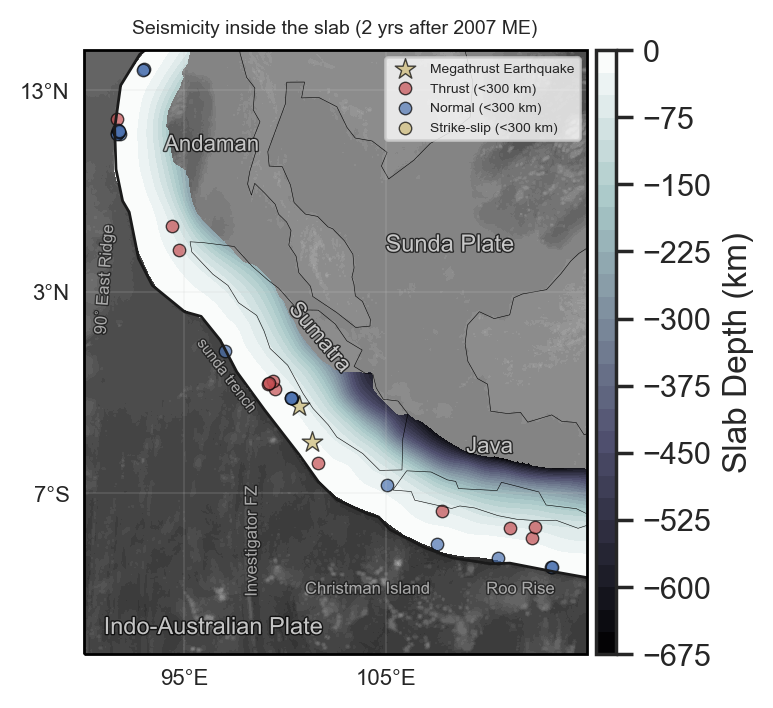

In [28]:
fig, ax = plt.subplots(dpi = 200)
m = plt.axes(projection = cartopy.crs.PlateCarree())

topo = m.contourf(lon, lat, z, 30,
    transform=ccrs.PlateCarree(), cmap='gray')

slab = m.contourf(lon_slab, lat_slab, depth_slab, 30,
    transform=ccrs.PlateCarree(), cmap='bone')

plt.colorbar(slab, label="Slab Depth (km)", orientation="vertical", aspect=30, pad=0.01, shrink=1)

plt.text(94, 10, 'Andaman', transform=ccrs.PlateCarree(), color='white', fontsize=8, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(100, -1, 'Sumatra', transform=ccrs.PlateCarree(), color='white', fontsize=8, rotation=-50, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(109, -5, 'Java', transform=ccrs.PlateCarree(), color='white', fontsize=8, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

plt.text(95.5, -3, 'sunda trench', transform=ccrs.PlateCarree(), color='white', fontsize=5.5, rotation=-53, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

plt.text(98, -12, 'Investigator FZ', transform=ccrs.PlateCarree(), color='white', fontsize=6, rotation=90, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(101, -12, 'Christman Island', transform=ccrs.PlateCarree(), color='white', fontsize=6, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(110, -12, 'Roo Rise', transform=ccrs.PlateCarree(), color='white', fontsize=6, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(90.5, 1, '90˚ East Ridge', transform=ccrs.PlateCarree(), color='white', fontsize=6, rotation=86, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])


plt.text(91, -14, 'Indo-Australian Plate', transform=ccrs.PlateCarree(), color='white', fontsize=8.5, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(105, 5, 'Sunda Plate', transform=ccrs.PlateCarree(), color='white', fontsize=8.5, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

m.set_extent([90, 115, -15, 15])

m.add_feature(cartopy.feature.COASTLINE, linewidth = 0.2)
# m.add_feature(cartopy.feature.LAND, linewidth = 0.5, color='grey')
# m.add_feature(cartopy.feature.OCEAN, linewidth = 0.5, color='grey', alpha=0.5)
gl = m.gridlines(linewidth = 0.1, draw_labels = True)
gl.xlocator = mticker.FixedLocator(np.arange(85-10, 125+20, 10))
gl.ylocator = mticker.FixedLocator(np.arange(-17-10, 30+20, 10))
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 8}
gl.xlabel_style = {'size': 8}

#plot events
m.scatter(data_mega['LON'][2], data_mega['LAT'][2], marker = '*', s = 60, c = 'y', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Megathrust Earthquake')
m.scatter(data_mega['LON'][4], data_mega['LAT'][4], marker = '*', s = 60, c = 'y', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree())


# m.scatter(data_T_DW_b2004['LON'], data_T_DW_b2004['LAT'], s = 20, c = 'r', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Thrust (<300 km)')
# m.scatter(data_N_DW_b2004['LON'], data_N_DW_b2004['LAT'], s = 20, c = 'b', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Normal (<300 km)')
# m.scatter(data_SS_DW_b2004['LON'], data_SS_DW_b2004['LAT'], s = 20, c = 'y', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Strike-slip (<300 km)')

# m.scatter(data_T_DW_a2004['LON'], data_T_DW_a2004['LAT'], s = 20, c = 'r', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Thrust (<300 km)')
# m.scatter(data_N_DW_a2004['LON'], data_N_DW_a2004['LAT'], s = 20, c = 'b', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Normal (<300 km)')
# m.scatter(data_SS_DW_a2004['LON'], data_SS_DW_a2004['LAT'], s = 20, c = 'y', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Strike-slip (<300 km)')

# m.scatter(data_T_DW_a2005['LON'], data_T_DW_a2005['LAT'], s = 20, c = 'r', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Thrust (<300 km)')
# m.scatter(data_N_DW_a2005['LON'], data_N_DW_a2005['LAT'], s = 20, c = 'b', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Normal (<300 km)')
# m.scatter(data_SS_DW_a2005['LON'], data_SS_DW_a2005['LAT'], s = 20, c = 'y', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Strike-slip (<300 km)')

m.scatter(data_T_DW_a2007['LON'], data_T_DW_a2007['LAT'], s = 20, c = 'r', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Thrust (<300 km)')
m.scatter(data_N_DW_a2007['LON'], data_N_DW_a2007['LAT'], s = 20, c = 'b', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Normal (<300 km)')
m.scatter(data_SS_DW_a2007['LON'], data_SS_DW_a2007['LAT'], s = 20, c = 'y', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Strike-slip (<300 km)')


# plt.text(96, 4, 'Mw 9.0 (2004)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
# plt.text(98.5, 3, 'Mw 8.6 (2005)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
# plt.text(96, -5, 'Mw 8.5 (2007)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
# plt.text(101, -2.5, 'Mw 7.9 (2007)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])



m.plot(trench_xy['LON'], trench_xy['LAT'], '-', c = 'k', linewidth = 1)
m.legend(loc = 'upper right', fontsize = 5)

plt.title('Seismicity inside the slab (2 yrs after 2007 ME)', fontsize=7)
# plt.title('Seismicity inside the slab (between 2005 & 2007 ME)', fontsize=6)

plt.savefig('dw_2007-09.jpg', dpi = 300, transparent= True, bbox_inches='tight')

# 1, 2, 3 - r, theta, phi 
# M11, M22, M33, M12, M13, M23 - Mrr, Mtt, Mpp, Mrt, Mpr, Mtp

## DW T, N, P axes maps

In [29]:
df_to_use = data_DW_a2007.reset_index() # resetting of index is important

In [30]:
data_UP.columns

Index(['LON', 'LAT', 'DEPTH', 'DATE', 'TIME', 'EVENT_ID', 'DEPFIX', 'DEPQUAL',
       'EX', 'MO', 'MW', 'EX.1', 'MRR', 'MTT', 'MPP', 'MRT', 'MTP', 'MPR',
       'STRIKE', 'DIP', 'RAKE', 'STRIKE.1', 'DIP.1', 'RAKE.1', 'EX.2', 'T_VAL',
       'T_PL', 'T_AZM', 'P_VAL', 'P_PL', 'P_AZM', 'N_VAL', 'N_PL', 'N_AZM',
       'SLAB_DIP', 'CLASS', 'P(km)', 'Q(km)', 'R(deg)', 'S(deg)', 'ALONG',
       'PROF', 'TTSUM', 'SINSQ_T', 'SINSQ_SS', 'SINSQ_N', 'TYPE', 'CORR_T_PL',
       'CORR_N_PL', 'CORR_P_PL', 'SINSQ_T_2', 'SINSQ_SS_2', 'SINSQ_N_2',
       'TYPE_2', 'CLASS1', 'TYPE1', 'Unnamed: 56', 'CLASS.1', 'Unnamed: 58',
       'Unnamed: 59'],
      dtype='object')

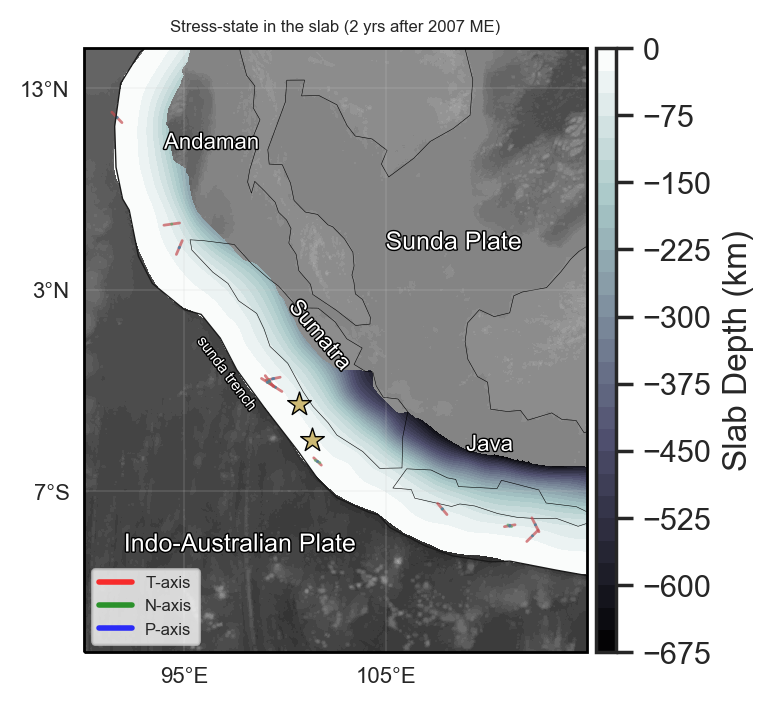

In [31]:
fig, ax = plt.subplots(dpi = 200)


m = plt.axes(projection = cartopy.crs.PlateCarree())

topo = m.contourf(lon, lat, z, 30,
    transform=ccrs.PlateCarree(), cmap='gray')

slab = m.contourf(lon_slab, lat_slab, depth_slab, 30,
    transform=ccrs.PlateCarree(), cmap='bone')

plt.colorbar(slab, label="Slab Depth (km)", orientation="vertical", aspect=30, pad=0.01, shrink=1)

plt.text(94, 10, 'Andaman', transform=ccrs.PlateCarree(), color='white', fontsize=8,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

plt.text(100, -1, 'Sumatra', transform=ccrs.PlateCarree(), color='white', fontsize=8, rotation=-50,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(109, -5, 'Java', transform=ccrs.PlateCarree(), color='white', fontsize=8,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(95.5, -3, 'sunda trench', transform=ccrs.PlateCarree(), color='white', fontsize=5.5, rotation=-53,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(92, -10, 'Indo-Australian Plate', transform=ccrs.PlateCarree(), color='white', fontsize=9,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(105, 5, 'Sunda Plate', transform=ccrs.PlateCarree(), color='white', fontsize=9,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

m.set_extent([90, 115, -15, 15])

m.add_feature(cartopy.feature.COASTLINE, linewidth = 0.2)
# m.add_feature(cartopy.feature.LAND, linewidth = 0.5, color='grey')
# m.add_feature(cartopy.feature.OCEAN, linewidth = 0.5, color='grey', alpha=0.5)
gl = m.gridlines(linewidth = 0.1, draw_labels = True)
gl.xlocator = mticker.FixedLocator(np.arange(85-10, 125+20, 10))
gl.ylocator = mticker.FixedLocator(np.arange(-17-10, 30+20, 10))
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 8}
gl.xlabel_style = {'size': 8}

#plot mega events as stars
m.scatter(data_mega['LON'][2], data_mega['LAT'][2], marker = '*', s = 80, c = 'y', alpha = 1, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Megathrust Earthquakes (Mw ≥ 7.9)')
m.scatter(data_mega['LON'][4], data_mega['LAT'][4], marker = '*', s = 80, c = 'y', alpha = 1, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Megathrust Earthquakes (Mw ≥ 7.9)')


# add the T, N, P visualizations
# sine ang dx
t_dx = 0.4*(np.sin(df_to_use['T_PL']*np.pi/180)**2)*np.sin(df_to_use['T_AZM']*np.pi/180)
t_dy = 0.4*(np.sin(df_to_use['T_PL']*np.pi/180)**2)*np.cos(df_to_use['T_AZM']*np.pi/180)

n_dx = 0.4*(np.sin(df_to_use['N_PL']*np.pi/180)**2)*np.sin(df_to_use['N_AZM']*np.pi/180)
n_dy = 0.4*(np.sin(df_to_use['N_PL']*np.pi/180)**2)*np.cos(df_to_use['N_AZM']*np.pi/180)

p_dx = 0.4*(np.sin(df_to_use['P_PL']*np.pi/180)**2)*np.sin(df_to_use['P_AZM']*np.pi/180)
p_dy = 0.4*(np.sin(df_to_use['P_PL']*np.pi/180)**2)*np.cos(df_to_use['P_AZM']*np.pi/180)

for idx, row in df_to_use.iterrows():
    # plot T
    plt.plot([row['LON'] + t_dx[idx], row['LON'] - t_dx[idx]], [row['LAT'] + t_dy[idx], row['LAT'] - t_dy[idx]], '-', linewidth = 1, c = 'r', transform=cartopy.crs.PlateCarree(), alpha = 0.7)
    plt.plot([row['LON'] + n_dx[idx], row['LON'] - n_dx[idx]], [row['LAT'] + n_dy[idx], row['LAT'] - n_dy[idx]], '-', linewidth = 1, c = 'g', transform=cartopy.crs.PlateCarree(), alpha = 0.7)
    plt.plot([row['LON'] + p_dx[idx], row['LON'] - p_dx[idx]], [row['LAT'] + p_dy[idx], row['LAT'] - p_dy[idx]], '-', linewidth = 1, c = 'b', transform=cartopy.crs.PlateCarree(), alpha = 0.7)

    # plot N
    # plot P



 # manual legend
colors = ['red', 'green', 'blue']
lines = [Line2D([0], [0], color=c, linewidth=2, linestyle='-', alpha = 0.8) for c in colors]
labels = ['T-axis', 'N-axis', 'P-axis']

m.plot(trench_xy['LON'], trench_xy['LAT'], '-', c = 'k', linewidth = 0.5)
m.legend(lines, labels, loc = 'lower left', fontsize = 6)

# plt.text(96, 4, 'Mw 9.0 (2004)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
# plt.text(98.5, 3, 'Mw 8.6 (2005)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
# plt.text(96, -5, 'Mw 8.5 (2007)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
# plt.text(101, -2.5, 'Mw 7.9 (2007)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])


plt.title('Stress-state in the slab (2 yrs after 2007 ME)', fontsize=6)

plt.savefig('dw_TNP_2007-09.jpg', dpi = 300, transparent= True, bbox_inches='tight')

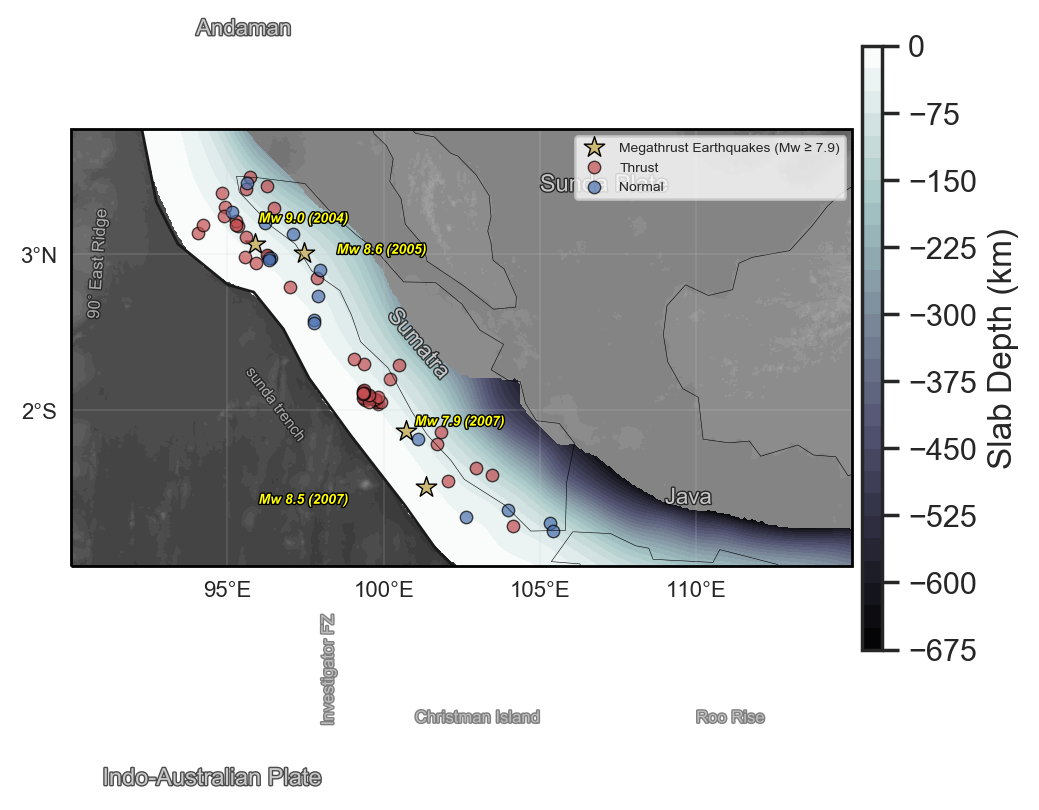

In [32]:
data_sum = data_UP[(data_UP['LAT'] >= -6) & (data_UP['LAT'] <= 6)]

data_sum_T = data_sum[(data_sum['MRR'] > 0)]
data_sum_T = data_sum_T[(data_sum_T['TYPE'] == 'THRUST') | (data_sum_T['TYPE'] == 'O_THRUST')]

data_sum_N = data_sum[(data_sum['MRR'] < 0)]
data_sum_N = data_sum_N[(data_sum_N['TYPE'] == 'NORM')]

# data_T_UP_b2004 = data_T_UP[(data_T_UP['DATE'] < '2004-12-25')]
# data_T_UP_a2004 = data_T_UP[(data_T_UP['DATE'] > '2004-12-25') & (data_T_UP['DATE'] < '2005-03-27')]
# data_T_UP_a2005 = data_T_UP[(data_T_UP['DATE'] > '2005-03-27') & (data_T_UP['DATE'] < '2007-09-11')]
# data_T_UP_a2007 = data_T_UP[(data_T_UP['DATE'] > '2007-09-11') & (data_T_UP['DATE'] < '2015-09-11')]


fig, ax = plt.subplots(dpi = 200)
m = plt.axes(projection = cartopy.crs.PlateCarree())

topo = m.contourf(lon, lat, z, 30,
    transform=ccrs.PlateCarree(), cmap='gray')

slab = m.contourf(lon_slab, lat_slab, depth_slab, 30,
    transform=ccrs.PlateCarree(), cmap='bone')

plt.colorbar(slab, label="Slab Depth (km)", orientation="vertical", aspect=30, pad=0.01, shrink=1)

plt.text(94, 10, 'Andaman', transform=ccrs.PlateCarree(), color='white', fontsize=8, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(100, -1, 'Sumatra', transform=ccrs.PlateCarree(), color='white', fontsize=8, rotation=-50, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(109, -5, 'Java', transform=ccrs.PlateCarree(), color='white', fontsize=8, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

plt.text(95.5, -3, 'sunda trench', transform=ccrs.PlateCarree(), color='white', fontsize=5.5, rotation=-53, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

plt.text(98, -12, 'Investigator FZ', transform=ccrs.PlateCarree(), color='white', fontsize=6, rotation=90, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(101, -12, 'Christman Island', transform=ccrs.PlateCarree(), color='white', fontsize=6, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(110, -12, 'Roo Rise', transform=ccrs.PlateCarree(), color='white', fontsize=6, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(90.5, 1, '90˚ East Ridge', transform=ccrs.PlateCarree(), color='white', fontsize=6, rotation=86, alpha=0.5,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])


plt.text(91, -14, 'Indo-Australian Plate', transform=ccrs.PlateCarree(), color='white', fontsize=8.5, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(105, 5, 'Sunda Plate', transform=ccrs.PlateCarree(), color='white', fontsize=8.5, alpha=0.7,
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])


m.set_extent([90, 115, -7, 7])

m.add_feature(cartopy.feature.COASTLINE, linewidth = 0.2)
# m.add_feature(cartopy.feature.LAND, linewidth = 0.5, color='grey')
# m.add_feature(cartopy.feature.OCEAN, linewidth = 0.5, color='grey', alpha=0.5)
gl = m.gridlines(linewidth = 0.1, draw_labels = True)
gl.xlocator = mticker.FixedLocator(np.arange(85-10, 125+20, 5))
gl.ylocator = mticker.FixedLocator(np.arange(-17-10, 30+20, 5))
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 8}
gl.xlabel_style = {'size': 8}

# plot the trench
m.plot(trench_xy['LON'], trench_xy['LAT'], '-', c = 'k', linewidth = 1)

#plot mega events as stars
m.scatter(data_mega['LON'], data_mega['LAT'], marker = '*', s = 60, c = 'y', alpha = 1, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Megathrust Earthquakes (Mw ≥ 7.9)')
# add info of mega events
plt.text(96, 4, 'Mw 9.0 (2004)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(98.5, 3, 'Mw 8.6 (2005)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(96, -5, 'Mw 8.5 (2007)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
plt.text(101, -2.5, 'Mw 7.9 (2007)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
        path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

# plot all events
m.scatter(data_sum_T['LON'], data_sum_T['LAT'], s = 20, c = 'r', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Thrust')
m.scatter(data_sum_N['LON'], data_sum_N['LAT'], s = 20, c = 'b', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Normal')
# m.scatter(data_T_UP_a2005['LON'], data_T_UP_a2005['LAT'], s = 20, c = 'b', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Thrust (between 2005 and 2007 ME)')
# m.scatter(data_T_UP_a2007['LON'], data_T_UP_a2007['LAT'], s = 20, c = 'y', alpha = 0.7, edgecolor = 'black', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label = 'Thrust (After 2007 ME)')

m.legend(loc = 'upper right', fontsize = 5)
# plt.title('Seismicity in the Sunda upper plate', fontsize=9)
# plt.savefig('up_t_seis.jpg', dpi = 300, transparent= True, bbox_inches='tight')


# 1, 2, 3 - r, theta, phi 
# M11, M22, M33, M12, M13, M23 - Mrr, Mtt, Mpp, Mrt, Mpr, Mtp